In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

from parameters import *
from functions import *

filenames = dict()
execfile('filenames.sh', filenames)

%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

In [2]:
def read_words(filename):
    with file(filename) as f:
        return [line.split(',')[0] for line in f]
    
word_freq_experiment_words = read_words(filenames['word_freq_experiment_words'])
coocc_noise_experiment_words = read_words(filenames['coocc_noise_experiment_words'])

In [3]:
vectors = load_word2vec_binary(filenames['vectors_binary'])
vocab = list(vectors.index)
print 'vocab size: ', len(vocab)
norms = np.sqrt((vectors ** 2).sum(axis=1))

vocab size:  62017


## Compute the frequencies in the modified corpus

In [4]:
with file(filenames['corpus_modified']) as f:
    new_counts = count_words(f)
    total_words = sum(new_counts.values())

In [5]:
stats = pd.DataFrame({'occurrences': new_counts, 'L2_norm': norms}).dropna()
stats['occurrences_band'] = np.floor(np.log2(stats.occurrences)).astype(int)
stats['log2_frequency'] = np.log2(stats.occurrences * 1. / total_words)
stats.L2_norm.name = 'L2 norm'

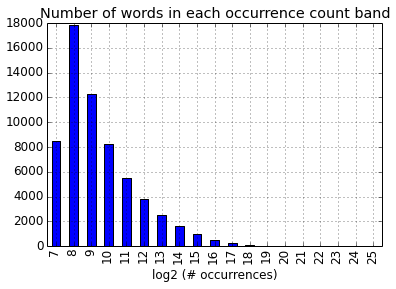

In [6]:
band_counts = stats.occurrences_band.dropna().value_counts().sort_index()
band_counts.index.name = 'log2 (# occurrences)'

_ = band_counts.plot(kind='bar', title='Number of words in each occurrence count band')

## The global relationship between L2 norm and frequency

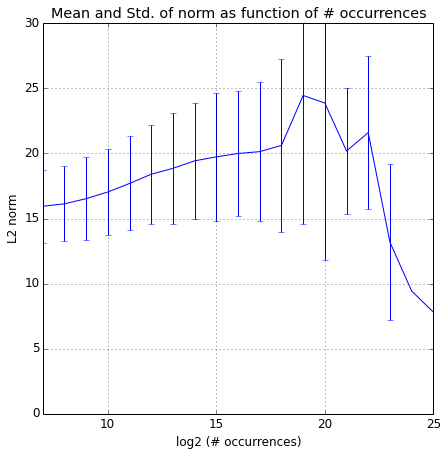

In [7]:
band_gb = stats.groupby('occurrences_band')

means = band_gb.L2_norm.mean()
errors = band_gb.L2_norm.std()
ax = means.plot(yerr=errors, title='Mean and Std. of norm as function of # occurrences', figsize=(7, 7), ylim=(0, 30))
_ = ax.set_xlabel('log2 (# occurrences)')
_ = ax.set_ylabel(stats.L2_norm.name)
plt.savefig('frequency-norm-graph.png')

In [8]:
def set_num_plots(num_plots):
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

## Word Frequency Experiment

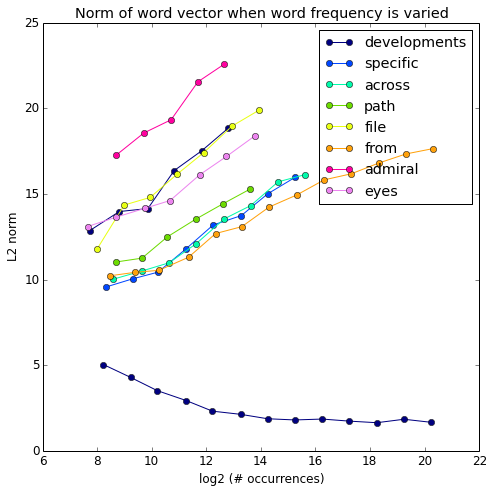

In [9]:
plt.figure(figsize=(7, 7))
plt.title('Norm of word vector when word frequency is varied')
plt.xlabel('log2 (# occurrences)')
plt.ylabel(stats.L2_norm.name)

set_num_plots(len(word_freq_experiment_words))

def plot_for_word(word, **kwargs):
    idxs = [build_experiment_token(word, i) for i in range(1, max(word_freq_experiment_ratio, word_freq_experiment_power_max) + 1)]
    x = np.log2(stats.loc[idxs].occurrences)
    y = stats.loc[idxs].L2_norm
    plt.plot(x, y, marker='o', **kwargs)

for word in word_freq_experiment_words + [meaningless_token]:
    plot_for_word(word)

_ = plt.legend(word_freq_experiment_words, loc='upper right')
plt.tight_layout()
plt.savefig('word-frequency-experiment-graph.png')

## Co-occurrence noise experiment

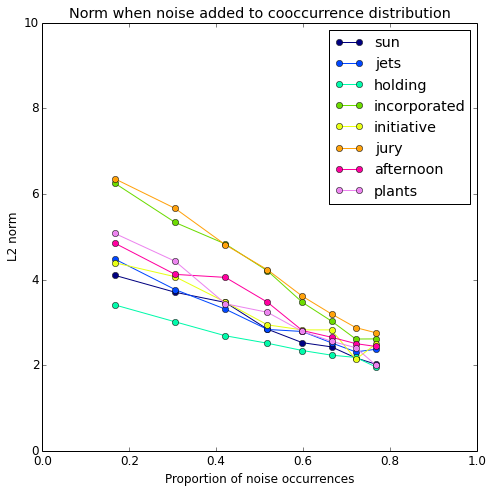

In [10]:
plt.figure(figsize=(7, 7))
plt.title('Norm when noise added to cooccurrence distribution')
plt.xlabel('Proportion of noise occurrences')
plt.ylabel(stats.L2_norm.name)
plt.ylim(0, 10)
plt.xlim(0, 1)

set_num_plots(len(coocc_noise_experiment_words))

def plot_for_word(word, **kwargs):
    exponents = filter(lambda i: build_experiment_token(word, i) in stats.index, range(1, coocc_noise_experiment_power_max + 1))
    idxs = [build_experiment_token(word, i) for i in exponents]
    x = [1 - coocc_noise_experiment_ratio ** exponent for exponent in exponents]
    y = stats.loc[idxs].L2_norm
    plt.plot(x, y, marker='o', **kwargs)

for word in coocc_noise_experiment_words:
    plot_for_word(word)

_ = plt.legend(coocc_noise_experiment_words, loc='upper right')
plt.tight_layout()

plt.savefig('cooccurrence-noise-graph.png')

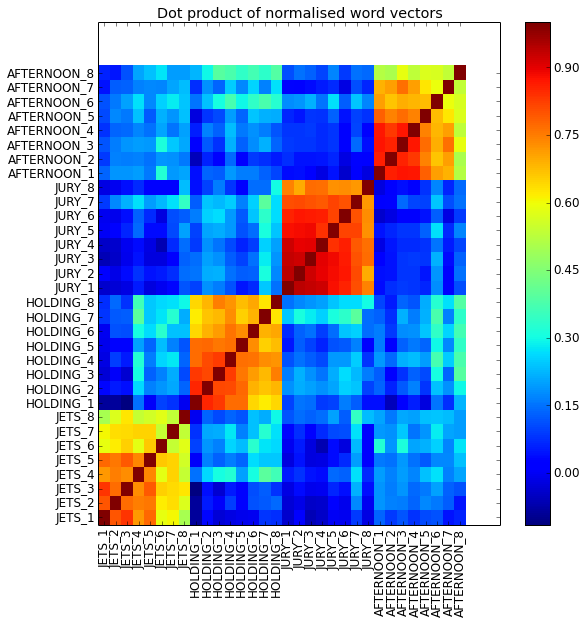

In [12]:
idxs = []
for word in random.sample(coocc_noise_experiment_words, 4):
    idxs += [build_experiment_token(word, i) for i in range(1, coocc_noise_experiment_power_max + 1)]

noisy_vecs = vectors.loc[idxs]
noisy_vecs_normed = noisy_vecs.as_matrix() / np.sqrt((noisy_vecs ** 2).sum(axis=1))[:,np.newaxis]
mat = noisy_vecs_normed.dot(noisy_vecs_normed.transpose())    
plt.figure(figsize=(9,9))
plt.title('Dot product of normalised word vectors')
plt.pcolor(mat)
plt.colorbar()
_ = plt.yticks(np.arange(0.5, len(noisy_vecs.index), 1), noisy_vecs.index)
_ = plt.xticks(np.arange(0.5, len(noisy_vecs.index), 1), noisy_vecs.index, rotation=90)

plt.savefig('cooccurrence-noise-heatmap.png')